
The objective of this file is to generate a list of timestamps for when a passenger
should initiate a trip between floors. 
This file generates a list of passengers, and their trips.
Additionally an array of tuples containing a timestamp in seconds 
from 6AM to around 7PM as well as a passenger id will generated
this indicates that the passenger should initiate a trip.

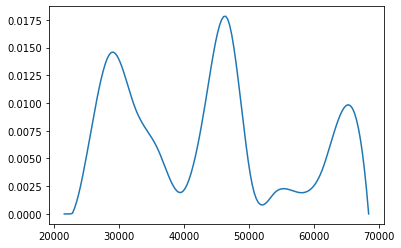

In [1]:
from passenger import *
import numpy as np
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import random


# // -------- Simulation Constants --------

simulation_params = {
    'floors': 50,
    'elevators': 10, 
    'loading_time': 6, # seconds
    'offloading_time': 6, # seconds
    'time_per_floor': 4, # seconds
    'floor_height': 4, # metres
    'dt': 1, # seconds simulation step interval
    'passengers': 1500,

}

hours = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
val =   np.array([0, 30, 75, 50, 30, 10, 50, 90, 15, 10, 10, 20, 50, 0])


h2s = 60 * 60

seconds = hours * 60 * 60
seconds_int = np.linspace(6 * h2s, 19 * h2s, num = 150, endpoint=True)
tk = interpolate.splrep(seconds, val)
val_int = interpolate.splev(seconds_int, tk)
val_int = val_int.clip(min=0)

start = np.min(seconds_int)
end = np.max(seconds_int)

simulation_params['start'] = start
simulation_params['end'] = end

norm_int = val_int / np.sum(val_int)

cum_int = np.cumsum(norm_int) 

plt.plot(seconds_int, norm_int)


The function below generates Passengers as well as the trips that they will make

*Assumptions*:
- Weights are normaly distributed mean: 65kg and standard deviation of 30kg (assuming luggage)
- passengers always start and end at floor 0.
- Passengers can make up to 7 trips in a day and at least 2 (one up and down)


In [2]:

def generatePassengers(n, sp):
    
    weights = np.random.normal(65, 30, n)
    trips = np.random.randint(3, 8, n)
    
    select = np.random.randint(0, sp['floors'], np.sum(trips - 2))
    select_index = 0

    out = []

    tripOwner = []

    for i in range(n):
        route = [0] * trips[i]

        tripOwner.extend([i] * (trips[i]-1))

        for y in range (1, trips[i]-1):
            route[y] = select[select_index]
            select_index = select_index + 1

            while(route[y] == route[y-1]):
                route[y] = np.random.randint(1, sp['floors'] - 1, 1)[0]

        # check last route is not 0
        while(route[trips[i]-2] == route[trips[i]-1]):
            route[trips[i]-2] = np.random.randint(1, sp['floors'] - 1, 1)[0]


        out.append(Passenger(weights[i], route))

    return {
        'passengers': out,
        'total_trips': sum(trips) - n,
        'trip_owner': tripOwner
    }


In [3]:
# Assume the building of 10 floors has 200 people

passengers = generatePassengers(simulation_params['passengers'], simulation_params)

print(passengers['total_trips'], len(passengers['trip_owner']))

5923 5923


In [4]:

shuffled_trips = list(passengers['trip_owner']); random.shuffle(shuffled_trips)

shuffled_trips[:20]


[413,
 91,
 1282,
 1497,
 1124,
 1365,
 1496,
 1411,
 607,
 515,
 1461,
 1433,
 1348,
 1037,
 1031,
 405,
 640,
 1274,
 507,
 370]

[22890, 23126, 23204, 23225, 23328, 23422, 23458, 23461, 23536, 23552, 23577, 23648, 23719, 23738, 23785, 23796, 23812, 23933, 23935, 23961, 23985, 24022, 24096, 24110, 24128, 24141, 24149, 24152, 24156, 24208, 24219, 24244, 24252, 24262, 24319, 24350, 24358, 24361, 24373, 24376, 24382, 24388, 24406, 24430, 24464, 24471, 24497, 24498, 24501, 24505]
minute grouping: 7.8


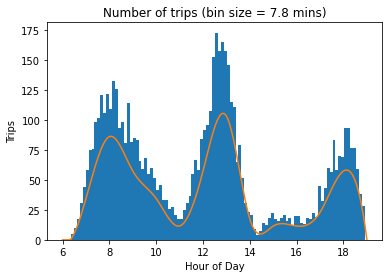

In [5]:
# sample timestamps for each trip

times = [round(np.interp(random.random(), cum_int, seconds_int)) for x in range(passengers['total_trips'])]

# times = times.sort()

times_scale = [x/(60*60) for x in times]

times.sort()
print(times[:50])

bins = 100

min_groups = ((end - start) / bins) / 60


print('minute grouping:', min_groups)
plt.hist(times_scale, bins)

plt.plot(seconds_int / (60*60), norm_int * passengers['total_trips'])
plt.title('Number of trips (bin size = '+ str(min_groups) + ' mins)')
plt.xlabel('Hour of Day')
plt.ylabel('Trips')

import io
import base64

iobytes = io.BytesIO()
plt.savefig(iobytes, format='jpg')
iobytes.seek(0)
distPlot = base64.b64encode(iobytes.read())



In [6]:
# export data:

import pickle

db = dict({
    'passengers': passengers['passengers'], 
    'traffic_times': times, 
    'traffic_passengers': shuffled_trips,
    'simulation_params': simulation_params,
    'distribution': str(distPlot),
})


filename = "p{}e{}f{}.bin".format(simulation_params['passengers'],simulation_params['elevators'], simulation_params['floors'])

with open(filename, 'wb') as f:
    pickle.dump(db, f)





In [7]:
str(distPlot)

"b'/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEgAbADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiig